In [1]:
!pip install Plotly

In [3]:
!pip install Lifetimes

In [4]:
import matplotlib.ticker as mtick #for specifying the axes tick format
%matplotlib inline
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

from lifetimes.utils import *
from lifetimes import BetaGeoFitter,GammaGammaFitter
from lifetimes.plotting import plot_probability_alive_matrix, plot_frequency_recency_matrix, plot_period_transactions, plot_cumulative_transactions,plot_incremental_transactions
from lifetimes.generate_data import beta_geometric_nbd_model
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases, plot_period_transactions,plot_history_alive
orders = pd.read_csv('olist_orders_dataset.csv')
items = pd.read_csv('olist_order_items_dataset.csv')
cust = pd.read_csv('olist_customers_dataset.csv')

In [5]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [6]:
cust.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [7]:
cust.describe()

,customer_zip_code_prefix
count,99441.000000
mean,35137.474583
std,29797.938996
min,1003.000000
25%,11347.000000
50%,24416.000000
75%,58900.000000
max,99990.000000


In [8]:
items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [9]:
cust.groupby('customer_unique_id').size().value_counts()

1     93099
2      2745
3       203
4        30
5         8
6         6
7         3
17        1
9         1
dtype: int64

In [10]:
cust.groupby('customer_id').size().value_counts()

1    99441
dtype: int64

In [11]:
orders=pd.merge(orders,cust[['customer_id','customer_unique_id']],on='customer_id')
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6


In [12]:
print(items.columns)
items.drop_duplicates('order_id',keep='first',inplace=True)  #to remove duplicate ids

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')


In [13]:
items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [14]:
transaction_data=pd.merge(orders,items,'inner','order_id')
transaction_data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


In [15]:
transaction_data=transaction_data[['customer_unique_id','order_purchase_timestamp','price']]

## convert timestamp to date; only need the day
transaction_data['date'] = pd.to_datetime(transaction_data['order_purchase_timestamp']).dt.date
transaction_data = transaction_data.drop('order_purchase_timestamp',axis=1)
transaction_data.head()


,customer_unique_id,price,date
0,7c396fd4830fd04220f754e42b4e5bff,29.99,2017-10-02
1,af07308b275d755c9edb36a90c618231,118.70,2018-07-24
2,3a653a41f6f9fc3d2a113cf8398680e8,159.90,2018-08-08
3,7c142cf63193a1473d2e66489a9ae977,45.00,2017-11-18
4,72632f0f9dd73dfee390c9b22eb56dd6,19.90,2018-02-13


In [16]:
summary = summary_data_from_transaction_data(transaction_data,'customer_unique_id','date',monetary_value_col='price',)
summary.describe()
#T= number of days from first purchase
#recency=no of days from last purchase
#monetary=mean of customer's purchases excluding the first purchase

,frequency,recency,T,monetary_value
count,95420.000000,95420.000000,95420.000000,95420.000000
mean,0.024198,2.683389,246.184846,2.474897
std,0.178936,25.263074,153.656402,26.579606
min,0.000000,0.000000,5.000000,0.000000
25%,0.000000,0.000000,122.000000,0.000000
50%,0.000000,0.000000,227.000000,0.000000
75%,0.000000,0.000000,356.000000,0.000000
max,15.000000,633.000000,729.000000,1999.990000


In [17]:
summary.head()

,frequency,recency,T,monetary_value
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,116.0,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,119.0,0.0
0000f46a3911fa3c0805444483337064,0.0,0.0,542.0,0.0
0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,326.0,0.0
0004aac84e0df4da2b147fca70cf8255,0.0,0.0,293.0,0.0


In [18]:
summary.tail()

,frequency,recency,T,monetary_value
customer_unique_id,,,,
fffcf5a5ff07b0908bd4e2dbc735a684,0.0,0.0,452.0,0.0
fffea47cd6d3cc0a88bd621562a9d061,0.0,0.0,267.0,0.0
ffff371b4d645b6ecea244b27531430a,0.0,0.0,573.0,0.0
ffff5962728ec6157033ef9805bacc48,0.0,0.0,124.0,0.0
ffffd2657e2aad2907e67c3e9daecbeb,0.0,0.0,489.0,0.0


In [19]:
summary[summary['frequency']>0].head()   #similar in sql

,frequency,recency,T,monetary_value
customer_unique_id,,,,
004288347e5e88a27ded2bb23747066c,1.0,171.0,403.0,87.90
004b45ec5c64187465168251cd1c9c2f,1.0,267.0,367.0,27.00
0058f300f57d7b93c477a131a59b36c3,1.0,31.0,196.0,72.58
00a39521eb40f7012db50455bf083460,1.0,11.0,103.0,11.55
011575986092c30523ecb71ff10cb473,1.0,60.0,198.0,63.90


In [20]:
transaction_data[transaction_data['customer_unique_id']=='004288347e5e88a27ded2bb23747066c']

,customer_unique_id,price,date
33396,004288347e5e88a27ded2bb23747066c,229.99,2017-07-27
39730,004288347e5e88a27ded2bb23747066c,87.90,2018-01-14


In [21]:
s1=summary[summary['frequency']>0]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000FCF2309D48>,
      dtype=object)

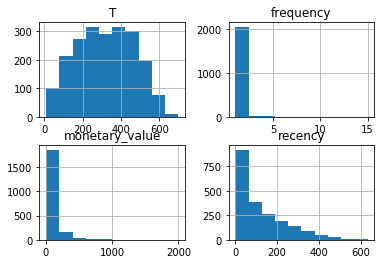

In [22]:
s1.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000FCF22A6988>]],
      dtype=object)

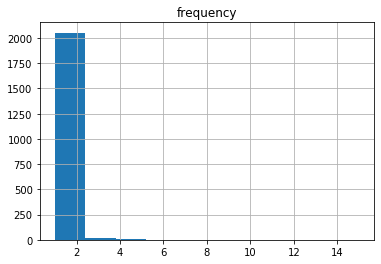

In [23]:
s1.hist('frequency')

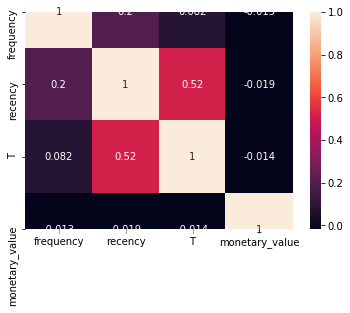

In [24]:
sns.heatmap(s1.corr(),annot=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000FCED35BD88>]],
      dtype=object)

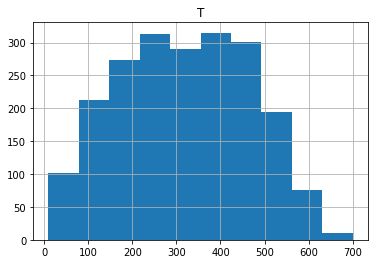

In [25]:
s1.hist('T')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000FCF2AB8748>]],
      dtype=object)

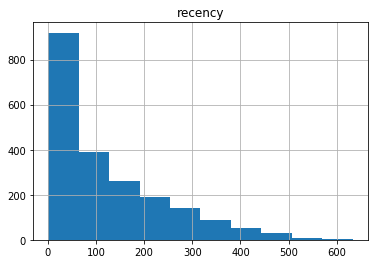

In [26]:
s1.hist('recency')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000FCF4B408C8>]],
      dtype=object)

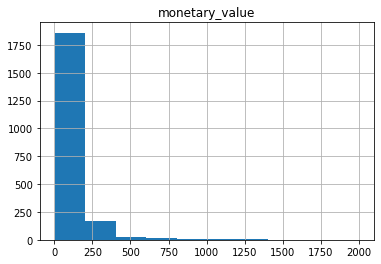

In [27]:
s1.hist('monetary_value')

In [28]:
s1.describe()

,frequency,recency,T,monetary_value
count,2085.000000,2085.000000,2085.000000,2085.000000
mean,1.107434,122.805276,319.304556,113.263645
std,0.515561,120.263432,146.803892,140.686377
min,1.000000,1.000000,10.000000,3.850000
25%,1.000000,25.000000,202.000000,40.900000
50%,1.000000,80.000000,321.000000,78.000000
75%,1.000000,188.000000,438.000000,135.910000
max,15.000000,633.000000,700.000000,1999.990000


In [29]:
bgf=BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary['frequency'],summary['recency'],summary['T'])

<lifetimes.BetaGeoFitter: fitted with 95420 subjects, a: 2.07, alpha: 65.86, b: 0.35, r: 0.02>

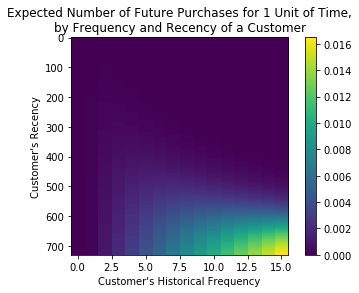

In [30]:
plot_frequency_recency_matrix(bgf);
#dark colour shows alive customers

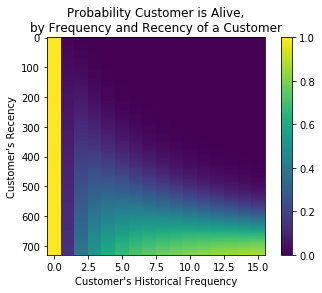

In [31]:
plot_probability_alive_matrix(bgf);